In [3]:
import pandas as pd
import plotly.express as px
import molplotly

import rdkit
from rdkit import Chem
from pipeline import draw_mols

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

from utils import convert_df_smis_to_fps, make_joined_list_of_fps_and_labels, tsne_from_pca_components, make_tsne_figure

# Part 1: Read in all data and pre-process

In [4]:
data_path = '../data/'
sample_size = 100000

abx = pd.read_csv(data_path + 'static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv')
print('num abx: ', len(abx))

gdb_dict = {}
for i in range(1,12):
    gdb = pd.read_csv(data_path + 'gdb/gdb13_CNOSCl/' + str(i) + '.smi', header = None)
    gdb.columns = ['SMILES']
    print('num mols in gdb-' + str(i) + ': ', len(gdb))
    if len(gdb) > sample_size:
        gdb = gdb.sample(n = sample_size)
    gdb_dict[i] = gdb
    
gdb17 = pd.read_csv(data_path + 'gdb/gdb17/GDB17.50000000.smi', header = None)
print('num gdb17: ', len(gdb17))
gdb17 = gdb17.sample(n = sample_size)
gdb17.columns = ['SMILES']

num abx:  566
num mols in gdb-1:  1
num mols in gdb-2:  3
num mols in gdb-3:  12
num mols in gdb-4:  43
num mols in gdb-5:  158
num mols in gdb-6:  953
num mols in gdb-7:  6041
num mols in gdb-8:  39589
num mols in gdb-9:  272598
num mols in gdb-10:  1915091
num mols in gdb-11:  13900390
num gdb17:  50000000


In [7]:
smis_abx, fp_abx = convert_df_smis_to_fps(abx, 'Smiles')
smis_gdbs, fp_gdbs = zip(*[convert_df_smis_to_fps(gdb_dict[i],'SMILES') for i in range(11,0,-1)]) # all the GDBs
smis_gdb11 = smis_gdbs[0] # just GDB-11
fp_gdb11 = fp_gdbs[0] # just GDB-11
smis_gdb17, fp_gdb17 = convert_df_smis_to_fps(gdb17, 'SMILES')


# Part 2: t-SNE with only GDBs

/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


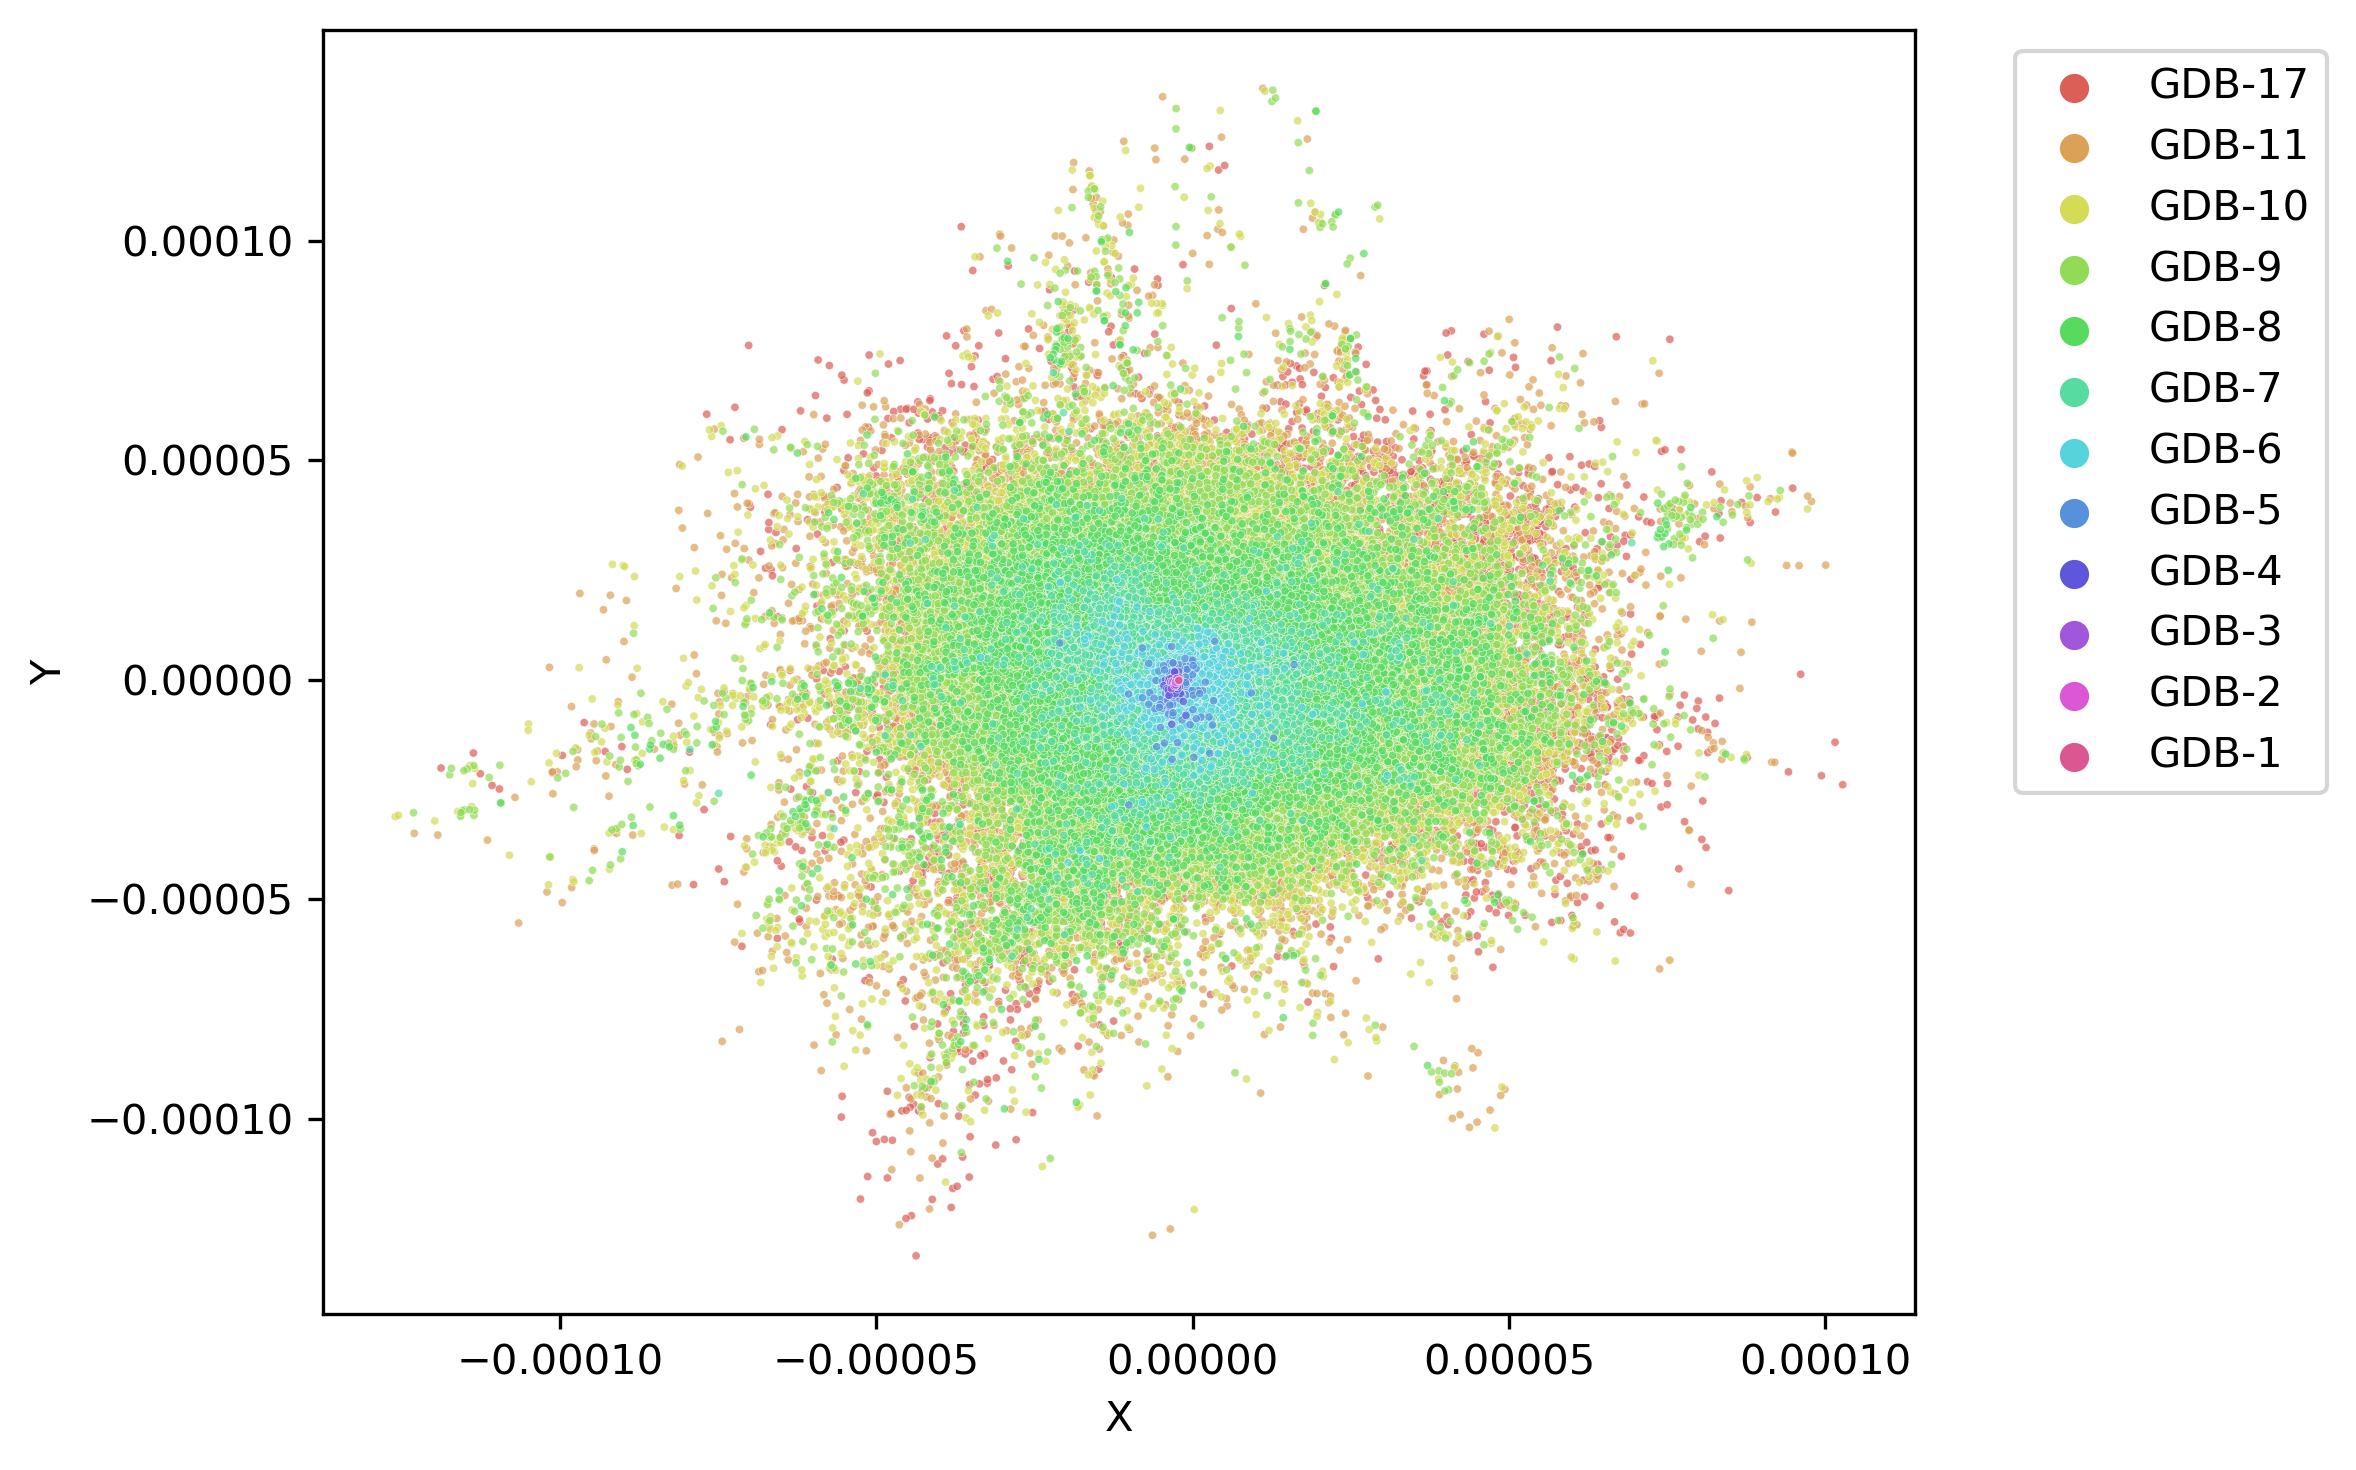

In [8]:
fps = [fp_gdb17]
fps.extend(fp_gdbs)

labels = ['GDB-17']
labels.extend(['GDB-' + str(i) for i in range(11,0,-1)])

fp_list, fp_labels = make_joined_list_of_fps_and_labels(fps, labels)

tsne_df = tsne_from_pca_components(fp_list, fp_labels)
make_tsne_figure(tsne_df, '../figure_panels/tsne_GDB1_thru_GDB17')

# Part 3: t-SNE with GDB-11, GDB-17, and known antibiotics

/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



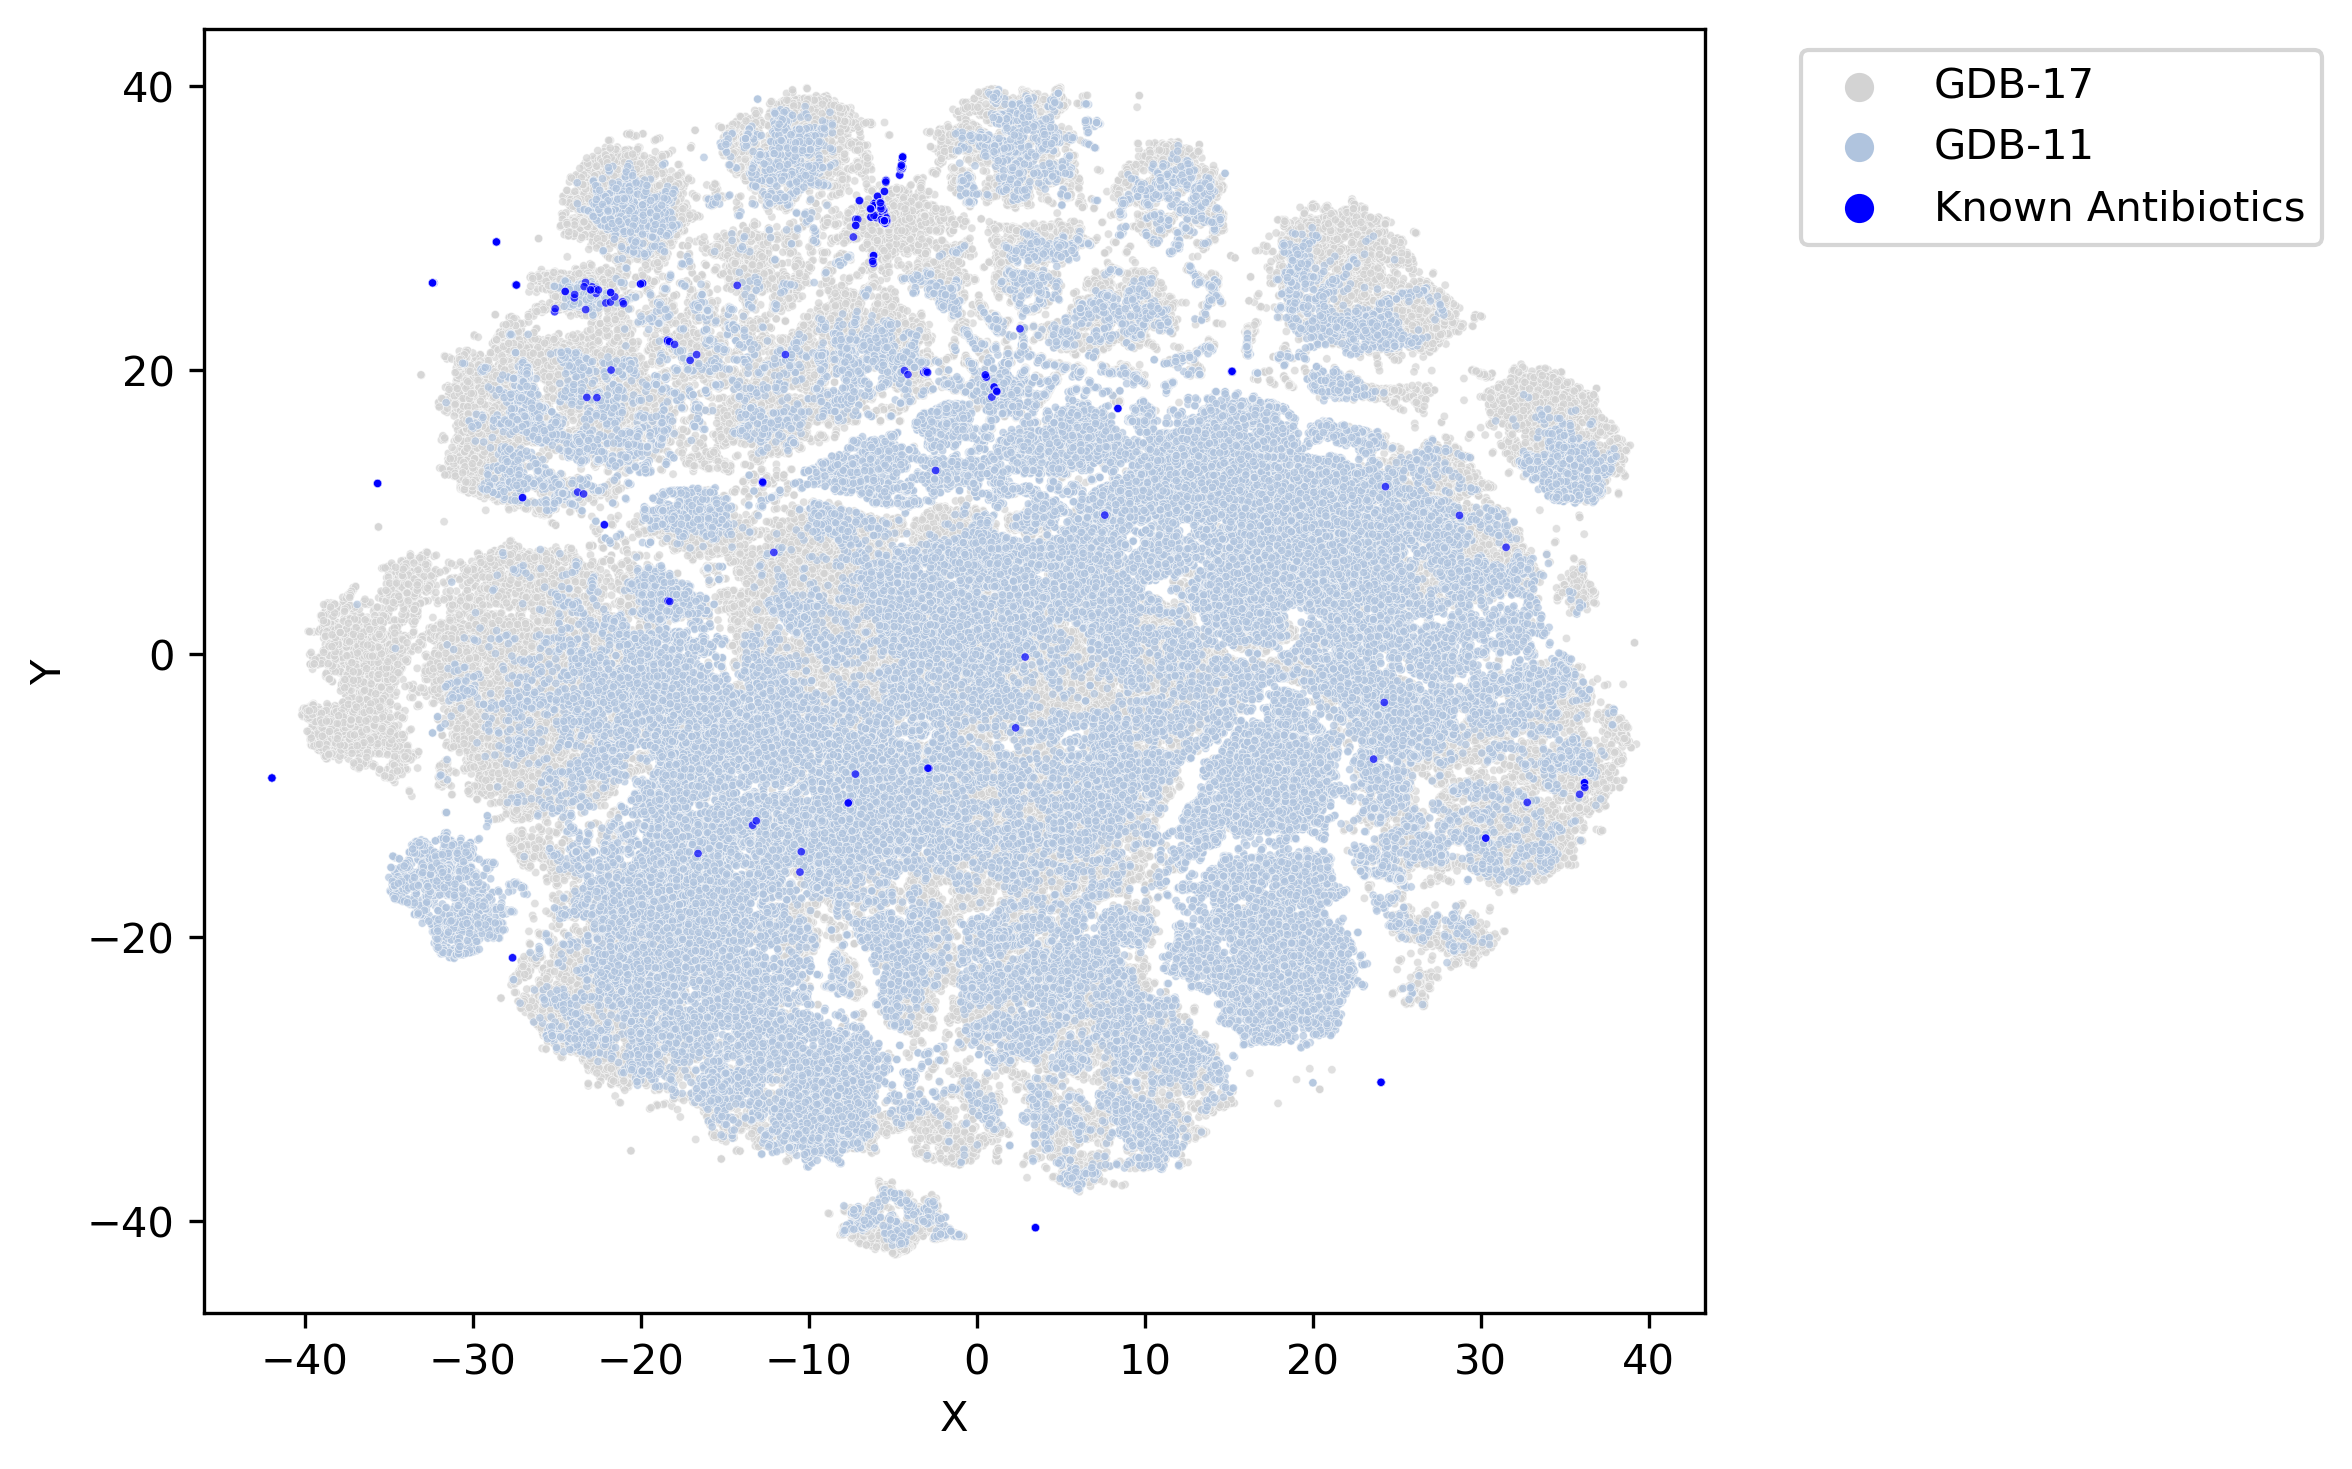

In [22]:
fps = [fp_gdb17, fp_gdb11, fp_abx]
labels = ['GDB-17', 'GDB-11', 'Known Antibiotics']
colors = ['lightgrey', 'lightsteelblue', 'blue']

fp_list, fp_labels = make_joined_list_of_fps_and_labels(fps, labels)
tsne_df = tsne_from_pca_components(fp_list, fp_labels)
make_tsne_figure(tsne_df, '../figure_panels/tsne_with_GDB11_17_abx', colors=colors)

# Part 4: need to make interactive t-SNE so can see where antibiotic scaffolds are

In [23]:
smis = list(smis_gdb17)
smis.extend(smis_gdb11)
smis.extend(smis_abx)

testdf = tsne_df
testdf['Smiles'] = smis

# clean up display so only 2 dec
abx = abx[['Smiles', 'Name', 'Class-Annotated']]
abx = abx.drop_duplicates('Smiles')
testdf = testdf.merge(abx, left_on = 'Smiles', right_on = 'Smiles', how = 'left')
testdf = testdf.fillna('N/A')
testdf.to_csv('../figure_panels/tsne_with_GDB11_17_abx_metadata.csv', index = False)

In [8]:
# actually make the interactive plot
testdf = pd.read_csv('../figure_panels/tsne_with_GDB11_17_abx_metadata.csv')

fig = px.scatter(testdf, x = 'X', y = 'Y', opacity = 0.75, color =  testdf['label'], color_discrete_sequence=colors)

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                                df=testdf,show_coords=False,
                                smiles_col='Smiles',color_col = 'label', caption_cols = ['label','Name', 'Class-Annotated'])
                                                                                        
# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=8700, height=500, host='localhost')

/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_10496/3700681346.py:2: DtypeWarning:

Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.



#### Display some of the compounds found from rerunning

In [9]:
sulfathiazole = Chem.MolFromSmiles('Nc1ccc(S(=O)(=O)Nc2nccs2)cc1')
gdb17LEFT = Chem.MolFromSmiles('CC1=CC(=CC(N)=C1N1C=NN=N1)S(N)(=O)=O')
gdb11RIGHT = Chem.MolFromSmiles('NC1=NC=CC2=C1S(=O)(=O)N2')
gdb17BOTTOM = Chem.MolFromSmiles('CC(O)(CO)S(=O)(=O)C1=CC=NC(=O)C(=O)O1')
gdb17TOP = Chem.MolFromSmiles('CC1COC1CNS(=O)(=O)C1=NOC(O)=C1C')

mols = [sulfathiazole, gdb17LEFT, gdb11RIGHT, gdb17BOTTOM, gdb17TOP]
draw_mols(mols, legends='', file_path = '../figure_panels/tsne_with_GDB11_17_abx_sulfa_groups.png')